In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

In [71]:
from CogDataset3d import show_test_accuracy, get_ds_dl
from unet3d_lightning_tabular import LitURNet3d

In [68]:
PATH_TO_MODEL = "/home/madar/unet2021/models/lightning_models/with_tabular/val_r2_epoch=0.5943_val_score_mse_loss_epoch=31.61_epoch=00.ckpt"

In [78]:
model = LitURNet3d.load_from_checkpoint(PATH_TO_MODEL, precision=16)

In [72]:
ds_train, ds_val, dl_train, dl_val = get_ds_dl()

len X_v: 240


In [124]:
def show_test_accuracy_2(nums, model, dl_test, batch_size=5, 
                       device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    use_amp = False
    model.eval()
    model.precision=16
    batch_losses = []
    total = 0
    correct = 0
    total_loss = 0
    i=0
    nums=3
    for x, y, y_score, filenames in dl_test:
        print(filenames)

        with torch.no_grad(): 
            y = y.squeeze(1).long()#.cuda()
            dim1,dim2,dim3,dim4 = y.size() #CHANGED
            x = x.view(dim1,1,dim2,dim3,dim4)#.cuda()
            total += dim1*dim2*dim3*dim4  
#             print(x.shape,y.shape)
            with torch.cuda.amp.autocast(enabled=use_amp): 

                total += y.shape[0]
                reg_out, y_hat, _ = model(x)
                loss = F.cross_entropy(y_hat, y)
                batch_losses.append(loss.item())
                pred = torch.max(y_hat, 1)[1]
                correct += (pred == y).float().sum().item()   

                for i in range(nums):
#                     slice_idx = random.randint(40,100)
                    slice_idx = 100
                    fig, ax = plt.subplots(3,3, figsize=(10,10))
#                     fig.set_facecolor("black")
                    ax=ax.flatten()
                    sag_record = [x[i][0,:,:,slice_idx], y[i][:,:,slice_idx], pred[i][:,:,slice_idx]]
                    hor_record = [x[i][0,:,slice_idx,:], y[i][:,slice_idx,:], pred[i][:,slice_idx,:]]
                    cor_record = [x[i][0,slice_idx,:,:], y[i][slice_idx,:,:], pred[i][slice_idx,:,:]]

                    for idx in range(0,3):
                        colormap = ["gray", "jet", "jet"]
                        ax[idx].imshow((sag_record[idx]).cpu().numpy().reshape(128,128), cmap=colormap[idx])
                        ax[idx+3].imshow((hor_record[idx]).cpu().numpy().reshape(128,128), cmap=colormap[idx])
                        ax[idx+6].imshow((cor_record[idx]).cpu().numpy().reshape(128,128), cmap=colormap[idx])
                    plt.savefig(f"compare_{filenames[i]}.png")
        break
                   
    print(f'\nCorrect predictions percentage is: {np.round((correct*100/total), 4)}')

['sub-ADNI002S0295_ses-M72_T1w', 'sub-ADNI002S0413_ses-M96_T1w', 'sub-ADNI002S1155_ses-M96_T1w', 'sub-ADNI002S1280_ses-M96_T1w', 'sub-ADNI002S2043_ses-M12_T1w', 'sub-ADNI002S4171_ses-M12_T1w', 'sub-ADNI002S4225_ses-M84_T1w', 'sub-ADNI003S0908_ses-M84_T1w', 'sub-ADNI003S4081_ses-M24_T1w', 'sub-ADNI003S4555_ses-M24_T1w']

Correct predictions percentage is: 95.2624


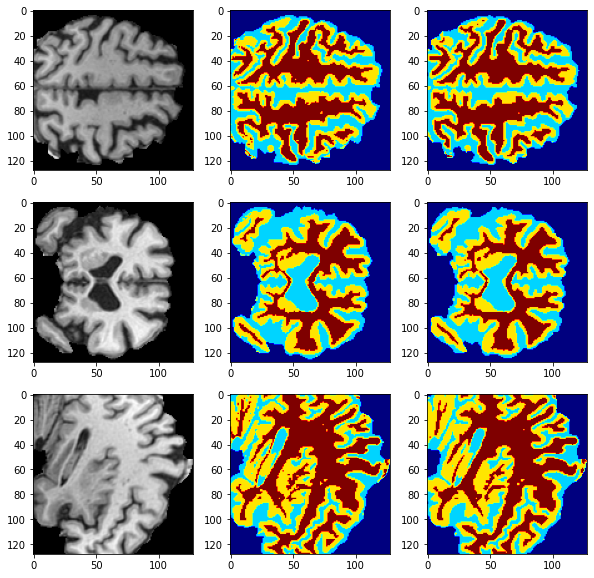

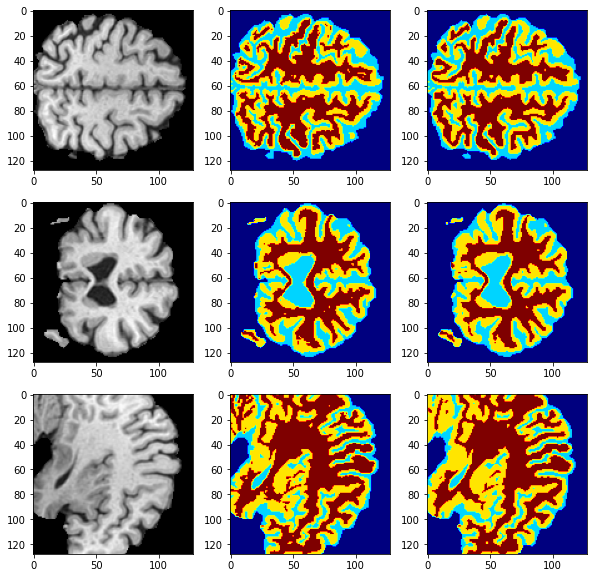

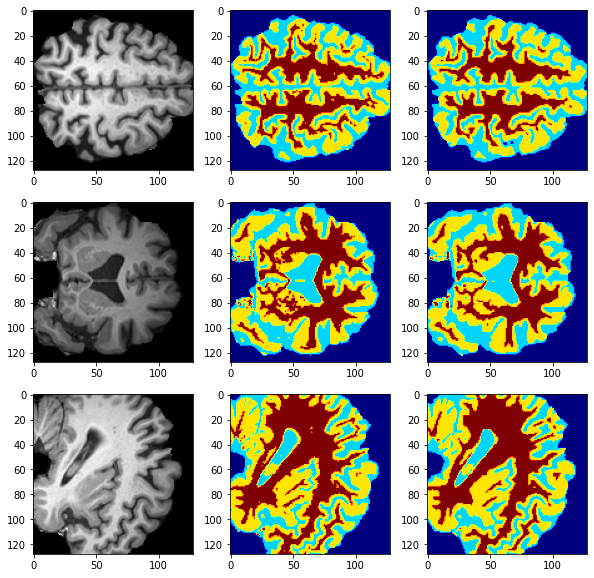

In [125]:
show_test_accuracy_2(nums=1, model=model, dl_test=dl_val, batch_size=5, 
                       device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [126]:
lst = 'sub-ADNI002S0295_ses-M72_T1w', 'sub-ADNI002S0413_ses-M96_T1w', 'sub-ADNI002S1155_ses-M96_T1w', 'sub-ADNI002S1280_ses-M96_T1w', 'sub-ADNI002S2043_ses-M12_T1w', 'sub-ADNI002S4171_ses-M12_T1w', 'sub-ADNI002S4225_ses-M84_T1w', 'sub-ADNI003S0908_ses-M84_T1w', 'sub-ADNI003S4081_ses-M24_T1w', 'sub-ADNI003S4555_ses-M24_T1w'

In [132]:
hc = "002S0295"
dem = "009S1354"

In [134]:
df.loc[df.filenames.str.contains("009S1354")]

,AGE,PTEDUCAT,APOE4,ADAS11,MMSE,ABETA_bl,TAU_bl,PTAU_bl,M,filenames,...,DX_bl_CN,DX_bl_EMCI,DX_bl_LMCI,DX_bl_SMC,PTGENDER_Female,PTGENDER_Male,PTGENDER_nan,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married
470,58.9,16,2.0,29.0,18,543.5,477.9,46.54,6,sub-ADNI009S1354_ses-M06_T1w,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
plt.imshow(vol[3][:,20,:], cmap="jet")

In [32]:
df = pd.read_csv("cleaned_df_5_31.csv")

In [3]:
df_volume = pd.read_csv("df_volume.csv")

In [28]:
df_volume.columns = ["Idx", "filenames", "Volume_BG", "Volume_CSF", "Volume_GM", "Volume_WM"]

In [3]:
df.columns

Index(['AGE', 'PTEDUCAT', 'APOE4', 'ADAS11', 'MMSE', 'ABETA_bl', 'TAU_bl',
       'PTAU_bl', 'M', 'filenames', 'DX_bl_AD', 'DX_bl_CN', 'DX_bl_EMCI',
       'DX_bl_LMCI', 'DX_bl_SMC', 'PTGENDER_Female', 'PTGENDER_Male',
       'PTGENDER_nan', 'PTMARRY_Divorced', 'PTMARRY_Married',
       'PTMARRY_Never married'],
      dtype='object')

In [9]:
dfg = df.groupby(["AGE", "PTEDUCAT"]).agg({"ADAS11":"first"}).reset_index()

In [15]:
520
139
184

184

In [14]:
843 - 659

184

In [13]:
dfg

,AGE,PTEDUCAT,ADAS11
0,55.0,14,15.00
1,55.0,16,8.00
2,55.0,17,6.00
3,55.1,18,10.33
4,55.5,19,1.00
...,...,...,...
838,89.6,16,4.00
839,90.1,20,3.00
840,90.3,13,31.00
841,90.3,17,16.00


In [34]:
df_final = pd.merge(df, df_volume, on="filenames", how="inner").drop(columns=["Idx"])

In [35]:
df_final.to_csv("Healthy_with_volume.csv")

In [33]:
df.loc[df.filenames.str.contains("S0006")]

,AGE,PTEDUCAT,APOE4,ADAS11,MMSE,ABETA_bl,TAU_bl,PTAU_bl,M,filenames,...,DX_bl_CN,DX_bl_EMCI,DX_bl_LMCI,DX_bl_SMC,PTGENDER_Female,PTGENDER_Male,PTGENDER_nan,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married
0,80.4,13,0.0,19.00,21,1002.240126,286.524536,27.657809,6,sub-ADNI100S0006_ses-M06_T1w,...,0,0,1,0,1,0,0,0,1,0
1,80.4,13,0.0,18.67,26,1002.240126,286.524536,27.657809,12,sub-ADNI100S0006_ses-M12_T1w,...,0,0,1,0,1,0,0,0,1,0
2,80.4,13,0.0,11.33,24,1002.240126,286.524536,27.657809,18,sub-ADNI100S0006_ses-M18_T1w,...,0,0,1,0,1,0,0,0,1,0
3,80.4,13,0.0,17.67,22,1002.240126,286.524536,27.657809,36,sub-ADNI100S0006_ses-M36_T1w,...,0,0,1,0,1,0,0,0,1,0
732,80.4,13,0.0,14.67,26,1002.240126,286.524536,27.657809,24,sub-ADNI100S0006_ses-M24_T1w,...,0,0,1,0,1,0,0,0,1,0


In [6]:
df_h60 = df.loc[(df.ADAS11<=18)]

In [11]:
filenames = df_h60.filenames

In [28]:
target_path = '/media/rajlab/sachin_data_1/userdata/daren/target/target_files/'
input_path = '/media/rajlab/sachin_data_1/userdata/daren/mri/'

In [9]:
# new_target = "sub-ADNI023S4115_ses-M84_T1w"

In [10]:
# target = nib.load(target_path + new_target + "_seg.nii").get_fdata()

In [7]:
from collections import Counter, defaultdict

In [10]:
# Counter(np.array(target).flatten())

In [47]:
raw_file = "sub-ADNI100S0006_ses-M18_T1w"

In [51]:
dementia_file = "sub-ADNI018S0057_ses-M18_T1w"

In [59]:
out = np.load(target_path + "extracted21.npy")

In [61]:
dementia_out = np.argmax(out[6], axis=0)

In [62]:
dementia_out.shape

(128, 128, 128)

In [48]:
target = nib.load(target_path + raw_file + "_seg.nii").get_fdata()
inp = nib.load(input_path + raw_file + ".nii.gz").get_fdata()

In [57]:
inp2, target2 = nib.load(input_path + dementia_file + ".nii.gz").get_fdata(), \
nib.load(target_path + dementia_file + "_seg.nii").get_fdata()

In [65]:
def plot_imshow(inp, target, out):
    fig, ax = plt.subplots(3, 3, figsize=(12, 12))
    ax[0][0].imshow(inp[100,:,:], cmap="gray",label="")
    ax[0][1].imshow(inp[:,100,:], cmap="gray",label="")
    ax[0][2].imshow(inp[:,:,100], cmap="gray",label="")

    ax[1][0].imshow(target[100,:,:], cmap="jet",label="")
    ax[1][1].imshow(target[:,100,:], cmap="jet",label="")
    ax[1][2].imshow(target[:,:,100], cmap="jet",label="")
    
    ax[2][0].imshow(out[100,:,:], cmap="jet",label="")
    ax[2][1].imshow(out[:,100,:], cmap="jet",label="")
    ax[2][2].imshow(out[:,:,100], cmap="jet",label="")
    
    fig.show()

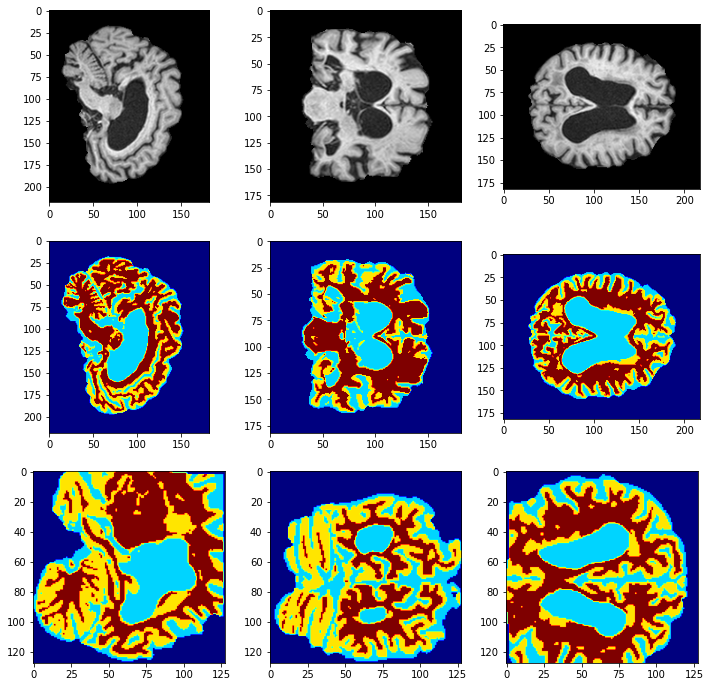

In [66]:
plot_imshow(inp2, target2, dementia_out)

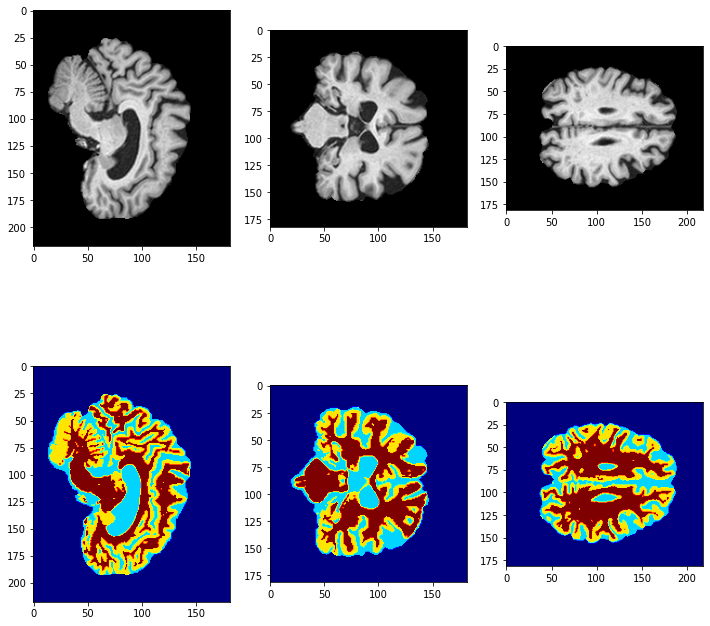

In [55]:
plot_imshow(inp, target)

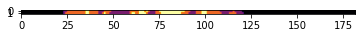

In [26]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(target[100,50:52,:], cmap='inferno',label="")

In [ ]:
deepblue 1 green 2 yellow 3

In [27]:
target[100,50:52,:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 3., 3., 2., 2., 2., 2., 2., 1., 1., 1., 2., 2., 2.,
        2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
        3., 3., 3., 2., 3., 2., 1., 1., 1., 2., 2., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 1., 1., 1., 2.,
        2., 2., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1.,
        1., 1., 1., 2., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 3., 3., 2.,

In [12]:
d = defaultdict(list)
for file in tqdm(filenames):
    d["filenames"].append(file)
    target = nib.load(target_path + file + "_seg.nii").get_fdata()
    counts = Counter(np.array(target).flatten())
    d["V0"].append(counts[0.0])
    d["V1"].append(counts[1.0])
    d["V2"].append(counts[2.0])
    d["V3"].append(counts[3.0])


100%|███████████████████████████████████████| 1292/1292 [22:27<00:00,  1.04s/it]


In [13]:
df_volume = pd.DataFrame.from_dict(d)
df_volume.to_csv("df_volume.csv")

In [14]:
df_volume

,filenames,V0,V1,V2,V3
0,sub-ADNI100S0006_ses-M18_T1w,5735705,457451,564470,463406
1,sub-ADNI100S0006_ses-M36_T1w,5724835,451025,567195,477977
2,sub-ADNI100S0015_ses-M12_T1w,5516088,480107,663098,561739
3,sub-ADNI100S0015_ses-M36_T1w,5527012,490488,644225,559307
4,sub-ADNI100S5280_ses-M24_T1w,5348006,508828,753604,610594
...,...,...,...,...,...
1287,sub-ADNI023S4115_ses-M84_T1w,5646838,407156,608137,558901
1288,sub-ADNI007S4272_ses-M84_T1w,5892742,372165,478644,477481
1289,sub-ADNI068S4431_ses-M84_T1w,5665136,507831,558786,489279
1290,sub-ADNI116S4855_ses-M72_T1w,5771633,442753,509732,496914
